# Ayudantía 03 - Introducción a Machine Learning

En esta ayudantía aplicaremos conceptos básicos de Machine Learning, entenderemos cómo medir el desempeño de los algoritmos y por último aprendemos cuáles herramientas de Python pueden ayudarnos.

## Entrenando un algoritmo de regresión lineal 

Utilizaremos los datos municipales para crear un modelo de regresión que prediga la población la comuna en función de la variable que consideremos más apropiada dentro de los siguientes candidatos:
- Metros Parque
- Personas que Trabajan en el Municipio
- Presupuesto

Importamos lo que vamos a utilizar

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import datasets
import copy

Llamamos a los datasets necesarios y los convertimos en dataframes

In [3]:
df_codigos=pd.read_csv("codigos.csv",sep=";")
df_comunas=pd.read_csv("datos_comunas.csv")
df_presupuesto=pd.read_csv("presupuesto_2019.csv",sep=";")
df_poblacion=pd.read_csv("poblacion.csv",sep=";")

Luego hacemos la limpieza apropiada según los problemas con la variable presupuesto

In [4]:
df_presupuesto[df_presupuesto['PRESUPUESTO'] == 'No Recepcionado']
# Reemplazamos todos los "No Recepcionado" por un 0
df_presupuesto = df_presupuesto.replace('No Recepcionado', 0)
# Estamos sobreescribiendo la columna, diciendo que trate el tipo como entero
df_presupuesto['PRESUPUESTO'] = df_presupuesto['PRESUPUESTO'].astype(int)
df_presupuesto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CODIGO       345 non-null    int64 
 1   MUNICIPIO    345 non-null    object
 2   PRESUPUESTO  345 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.2+ KB


Generamos el merge necesario para utilizar el dataset de mejor manera

In [8]:
#1)Hacemos un merge de df_codigos y df_comunas 
df_final=pd.merge(df_codigos,df_comunas,left_on="Código Comuna 2018",right_on="id",how="outer")
#2)Hacemos un merge de df_final y df_presupuesto
df_final=pd.merge(df_final,df_presupuesto,left_on="Código Comuna 2018",right_on="CODIGO",how="outer")
#2)Hacemos un merge de df_final y df_población
df_final=pd.merge(df_final,df_poblacion,left_on="Código Comuna 2018",right_on="CODIGO",how="outer")

df_final=df_final[["Nombre Región","Nombre Provincia","Nombre Comuna","metros_plaza","metros_parque","personas_trabaja","PRESUPUESTO","POBLACIÓN"]]
df_final.head()


,Nombre Región,Nombre Provincia,Nombre Comuna,metros_plaza,metros_parque,personas_trabaja,PRESUPUESTO,POBLACIÓN
0,Tarapacá,Iquique,Iquique,58460.0,94824.0,271.0,59072234.0,216514.0
1,Tarapacá,Iquique,Alto Hospicio,130316.0,0.0,55.0,13984411.0,124150.0
2,Tarapacá,Tamarugal,Pozo Almonte,NaN,NaN,NaN,7613962.0,16683.0
3,Tarapacá,Tamarugal,Camiña,4050.0,0.0,8.0,1584008.0,1345.0
4,Tarapacá,Tamarugal,Colchane,2532.0,NaN,NaN,2500000.0,1556.0


### Escoger variable a utilizar

Para escoger la variable dentro de los candidatos, utilizaremos la medida de correlación y visualizaciones para apoyarnos en la toma de decisión 

Primero observamos las correlaciones, se puede ver que con la variable población, las mayores correlaciones se dan con persona_trabaja y con presupuesto, por lo que serán nuestros principales candidatos.

In [9]:
df_final.corr()


,metros_plaza,metros_parque,personas_trabaja,PRESUPUESTO,POBLACIÓN
metros_plaza,1.000000,-0.005430,0.065125,0.089088,0.106234
metros_parque,-0.005430,1.000000,-0.008201,-0.007577,-0.017666
personas_trabaja,0.065125,-0.008201,1.000000,0.835009,0.843984
PRESUPUESTO,0.089088,-0.007577,0.835009,1.000000,0.777995
POBLACIÓN,0.106234,-0.017666,0.843984,0.777995,1.000000


Luego realizamos gráficos de scatterplot para ver posibles relaciones

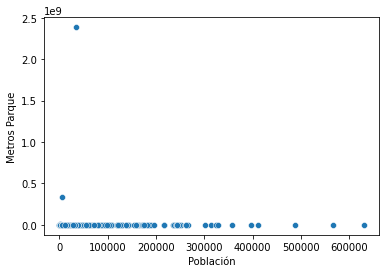

In [10]:
sns.scatterplot(data=df_final, x="POBLACIÓN", y="metros_parque")
plt.xlabel("Población")
plt.ylabel("Metros Parque")
plt.show()

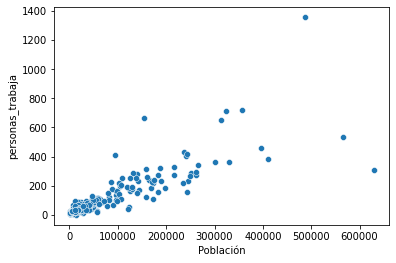

In [11]:
sns.scatterplot(data=df_final, x="POBLACIÓN", y="personas_trabaja")
plt.xlabel("Población")
plt.ylabel("personas_trabaja")
plt.show()

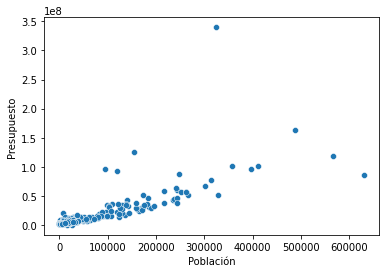

In [12]:
sns.scatterplot(data=df_final, x="POBLACIÓN", y="PRESUPUESTO")
plt.xlabel("Población")
plt.ylabel("Presupuesto")
plt.show()

De los gráficos podemos concluir cosas similares a la correlación, por lo que escogeré a persona_trabaja como variable para realizar la regresión.

### Entrenar modelo
- Dividimos en dos partes el dataset: entrenamiento y prueba
- Eliminamos las filas con valores nulos ya que impiden el correcto funcionamiento del modelo

In [16]:
from sklearn.model_selection import train_test_split

df_modelo=df_final[["personas_trabaja","POBLACIÓN"]]

df_modelo=df_modelo.dropna(axis=0)
train_set, test_set = train_test_split(df_modelo, test_size=0.3)

Seleccionamos cuáles serán nuestras variables X e y para luego entrenar el modelo SOLO con el dataset de entrenamiento

In [17]:
from sklearn.linear_model import LinearRegression

X_train = train_set[["personas_trabaja"]]
y_train = train_set[["POBLACIÓN"]]

lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Luego podemos probar el modelo evaluando en valores aleatorios. Entregamos cantidades de personas que trabajan en la municipalidad y nos entrega una predicción de la cantidad de poblacóin que tiene esta misma.

In [18]:
lin_reg.predict([[100], [200], [300]])

array([[ 66022.69486669],
       [139595.9478452 ],
       [213169.20082372]])

### Evaluar el modelo
Para evaluar el modelo podemos utilizar cross validation y R cuadrado.

Cross validation:

In [21]:
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()

X = df_modelo[["personas_trabaja"]]
y = df_modelo[["POBLACIÓN"]]

scores = cross_val_score(lin_reg, X, y, scoring='neg_mean_squared_error', cv=8)

lin_rmse_scores = np.sqrt(-scores)
print(lin_rmse_scores)

print(lin_rmse_scores.mean())
print(lin_rmse_scores.std())

[ 47951.33238839  24793.27521682  21908.31882231  17574.45353181
  23166.44533393  63154.13627169 110800.35298081  20980.28895513]
41291.07543761164
30218.51502173633


R cuadrado

In [22]:
from sklearn.metrics import r2_score

lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)
r2_score(y, y_pred)

0.7123096702725062

Se puede ver que el modelo explica en un 71%

Por último también se puede predecir el dataset de test completo

In [23]:
X_test = test_set[["personas_trabaja"]]
y_test = test_set[["POBLACIÓN"]]

lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

y_pred2 = lin_reg.predict(X_test)

y_pred2

array([[ 2.08754806e+05],
       [ 2.33502081e+04],
       [ 1.24145565e+05],
       [ 7.16409248e+03],
       [ 2.99718009e+04],
       [ 1.15784877e+04],
       [ 2.92628314e+05],
       [ 4.46864515e+04],
       [ 2.26144756e+04],
       [ 4.46864515e+04],
       [ 2.62931383e+04],
       [ 2.70288708e+04],
       [ 7.89982501e+03],
       [ 4.76293816e+04],
       [ 9.37129007e+03],
       [ 2.70288708e+04],
       [ 2.48216732e+04],
       [-1.66469787e+03],
       [ 1.59928828e+04],
       [ 8.63555754e+03],
       [ 5.42499716e+02],
       [ 4.10077889e+04],
       [ 4.02720563e+04],
       [ 9.03018683e+04],
       [ 1.82000804e+04],
       [ 1.30499527e+04],
       [ 7.16409248e+03],
       [ 8.63555754e+03],
       [ 2.62931383e+04],
       [ 9.90102752e+05],
       [ 2.48216732e+04],
       [ 6.74941599e+04],
       [ 1.94040155e+05],
       [ 1.08427551e+04],
       [ 2.89685384e+05],
       [ 2.40859407e+04],
       [ 1.45214178e+04],
       [ 8.63555754e+03],
       [ 6.0

## Entrenando un clasificador
Para este caso utilizaremos un nuevo dataset: Estudiantes. Este dataset muestra los puntajes que obtuvieron los alumnos en sus pruebas de lectura, escritura, matemáticas y por último el tipo de almuerzo que comen: los que no comen o comen poco y los que comen uno estándar.
Vamos a pedir que clasifique el tipo de almuerzo del alumno.

Primero llamamos al dataset y observamos. La columna de almuerzo está en dos formatos: int y object, por lo que podemos escoger la que más nos acomode para realizar la clasificación

In [28]:
df_estudiantes=pd.read_csv("Estudiantes.csv")
df_estudiantes

,Unnamed: 0,math_score,reading_score,writing_score,lunch,lunch_encoded
0,0,72,72,74,standard,1.0
1,1,69,90,88,standard,1.0
2,2,90,95,93,standard,1.0
3,3,47,57,44,free/reduced,0.0
4,4,76,78,75,standard,1.0
...,...,...,...,...,...,...
995,995,88,99,95,standard,1.0
996,996,62,55,55,free/reduced,0.0
997,997,59,71,65,free/reduced,0.0
998,998,68,78,77,standard,1.0


In [37]:
#Nos quedamos con las columnas que vamos a utilizar
df_estudiantes=df_estudiantes[['math_score','reading_score','writing_score','lunch_encoded']]

#Divimos en X e y
X, y = df_estudiantes[['math_score','reading_score','writing_score']], df_estudiantes['lunch_encoded']

#Luego en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Entrenamos el modelo

In [50]:
from sklearn.linear_model import SGDClassifier

# Modelo que vamos a entrenar
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)


#Predecimos
y_pred = sgd_clf.predict(X_test)
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

### Evaluamos el modelo generado

In [46]:
#Calculamos matriz de confusión
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[ 14  89]
 [  3 194]]


In [44]:
#Calculamos accuracy
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.6933333333333334


In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score

#Calculamos precision
print(precision_score(y_test, y_pred))

0.6855123674911661


In [49]:
#Calculamos recall
print(recall_score(y_test, y_pred))

0.9847715736040609


¿Qué se puede decir de estos valores?¿Cómo podrían mejorar?

¿En qué situaciones nos convienen mayores valores de precision vs mayores de recall?